In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm, tqdm_notebook

# This notebook seeks to use all OFET processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This first NN will only use processing conditions to try to predict performance

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. 

*_Note:_* This DataFrame will only contain devices with reasonable performance values.

### Outputs:
- Tensor of predicted performance for given processing conditions

In [3]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OFET_device_df.xlsx')
print (device_df.shape)
device_df.head()

(80, 15)


,Unnamed: 0,Unnamed: 0.1,Sample,Temperature,Time,Substrate,Device,mu_lin_avg,mu_lin_SD,r_lin_avg,r_lin_sd,on_off_avg,on_off_sd,Vt_avg,Vt_sd
0,0,0,75C-5min_1-IdVg-2-Vd-20,75,5,1,2,0.002176,0.000014,0.580171,0.013437,1119.582374,30.715757,-31.511376,0.198134
1,1,1,75C-5min_1-IdVg-4-Vd-20,75,5,1,4,0.004906,0.000259,0.551756,0.020972,892.258038,4.484375,-28.971871,0.461514
2,2,2,75C-5min_2-IdVg-1-Vd-20,75,5,2,1,0.004643,0.000015,0.557327,0.002400,20.595284,0.172757,-18.556867,0.166910
3,3,3,75C-5min_2-IdVg-3-Vd-20,75,5,2,3,0.012977,0.002372,0.581325,0.004444,619.347250,1024.656122,-21.054614,1.348128
4,4,4,75C-5min_2-IdVg-4-Vd-20,75,5,2,4,0.010087,0.000050,0.585769,0.006963,1812.113114,15.685197,-19.170370,0.165707


In [69]:
# Hyper parameters
num_epochs = 100
batch_size = 64
learning_rate = 0.01

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [70]:
X = device_df[['Time', 'Temperature']] #input features used to make prediction
Y = device_df[['mu_lin_avg', 'r_lin_avg', 'on_off_avg', 'Vt_avg']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor) #create tensor with features and targets
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True) #create iterable dataset with batches

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))
test_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [71]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 32)
        self.h_layer2 = nn.Linear(32, 16)
        self.h_layer3 = nn.Linear(16, 8)
        
        #output layer
        self.o_layer = nn.Linear(8, out_dims)
        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        out = self.h_layer3(out)
        
        #embedded data is passed to output layer
        out = self.o_layer(out)
        
        return out

In [72]:
def train_model(model, training_data_set, criterion, optimizer):
    train_epoch_loss = []
    train_losses = []
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    #wrapper to create progress bar & results for each epoch's training
    progress = tqdm_notebook(training_data_set, desc = 'Progress:', leave = True)
    
    for train_data, labels in progress:
        
        train_data = train_data.to(device)
        labels = labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        output = model(train_data) #gather model prediction for this loop
        loss = criterion(output, labels) #calculate error in the prediction
        
        #BACKPROPOGATE LIKE A MF
        loss.backward()
        optimizer.step()
        
        #send results to progress bar and save loss for this batch
        progress.set_description(f'Loss: {loss.item()}:.3f')
        train_losses.append(loss.item())
        train_total+=1              ## TODO: determine if test_total should be incremented by 1 or by labels.size(0
#         train_total += labels.size(0)
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    #update progress bar
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')
    
    return train_epoch_loss

In [73]:
def eval_model(model, testing_data_set, criterion, optimizer):
    #evaluate the model
    model.eval()

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
#         correct = 0
        test_losses = []
        test_total = 0

        for inputs, labels in testing_data_set:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

    #         predicted = torch.sigmoid(output).item() #TODO: need to figure out what/how classification is divided up
    
            # calculate loss per batch of testing data
            test_loss = criterion(outputs, labels)
            test_losses.append(test_loss.item())
            test_total += 1    ## TODO: determine if test_total should be incremented by 1 or by labels.size(0)
#             test_total += labels.size(0)

#             print (f"Test Loss: {test_loss}")

#             print (test_total)
    #         correct += (predicted == labels).sum().item()

    #     print ('Model accuracy is: ', ((correct/total)*100), '%')

        total_test_loss = sum(test_losses)/test_total

        print (f"Total testing loss is: {total_test_loss}")
    return total_test_loss

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [74]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (mu_lin, r_lin, on_off, Vt)
model = NN1(in_dims = 2, out_dims = 4).to(device)

#define the loss function and the optimizer
criterion = nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [75]:
#empty list to hold loss per epoch
train_epoch_losses = []
test_epoch_losses = []

for epoch in range(num_epochs):
    train_epoch_loss = train_model(model = model,
                                   training_data_set = training_data_set,
                                   criterion = criterion,
                                   optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    
    test_epoch_loss = eval_model(model = model,
                                 testing_data_set = testing_data_set,
                                 criterion = criterion,
                                 optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)


Epoch #1	Train Loss: 674854656.000
Total testing loss is: 285933856.0



Epoch #2	Train Loss: 674767744.000
Total testing loss is: 285879424.0



Epoch #3	Train Loss: 674678976.000
Total testing loss is: 285813216.0



Epoch #4	Train Loss: 674571072.000
Total testing loss is: 285726880.0



Epoch #5	Train Loss: 674429888.000
Total testing loss is: 285612224.0



Epoch #6	Train Loss: 674241920.000
Total testing loss is: 285460992.0



Epoch #7	Train Loss: 673993088.000
Total testing loss is: 285264192.0



Epoch #8	Train Loss: 673667968.000
Total testing loss is: 285011680.0



Epoch #9	Train Loss: 673248960.000
Total testing loss is: 284692480.0



Epoch #10	Train Loss: 672716032.000
Total testing loss is: 284293920.0



Epoch #11	Train Loss: 672045824.000
Total testing loss is: 283802304.0



Epoch #12	Train Loss: 671211712.000
Total testing loss is: 283203488.0



Epoch #13	Train Loss: 670184448.000
Total testing loss is: 282482880.0



Epoch #14	Train Loss: 668930752.000
Total testing loss is: 281627424.0



Epoch #15	Train Loss: 667415104.000
Total testing loss is: 280626208.0



Epoch #16	Train Loss: 665599808.000
Total testing loss is: 279473280.0



Epoch #17	Train Loss: 663446016.000
Total testing loss is: 278171200.0



Epoch #18	Train Loss: 660916416.000
Total testing loss is: 276737344.0



Epoch #19	Train Loss: 657979328.000
Total testing loss is: 275210144.0



Epoch #20	Train Loss: 654612800.000
Total testing loss is: 273659072.0



Epoch #21	Train Loss: 650812352.000
Total testing loss is: 272201216.0



Epoch #22	Train Loss: 646602944.000
Total testing loss is: 271018688.0



Epoch #23	Train Loss: 642052736.000
Total testing loss is: 270386400.0



Epoch #24	Train Loss: 637295744.000
Total testing loss is: 270700000.0



Epoch #25	Train Loss: 632558016.000
Total testing loss is: 272513856.0



Epoch #26	Train Loss: 628196992.000
Total testing loss is: 276540416.0



Epoch #27	Train Loss: 624729856.000
Total testing loss is: 283543648.0



Epoch #28	Train Loss: 622823616.000
Total testing loss is: 293850848.0



Epoch #29	Train Loss: 623090560.000
Total testing loss is: 306177984.0



Epoch #30	Train Loss: 625457920.000
Total testing loss is: 316754560.0



Epoch #31	Train Loss: 628437248.000
Total testing loss is: 321859104.0



Epoch #32	Train Loss: 630046400.000
Total testing loss is: 320951488.0



Epoch #33	Train Loss: 629649152.000
Total testing loss is: 315775296.0



Epoch #34	Train Loss: 627877824.000
Total testing loss is: 308508096.0



Epoch #35	Train Loss: 625688704.000
Total testing loss is: 300892288.0



Epoch #36	Train Loss: 623816384.000
Total testing loss is: 294027392.0



Epoch #37	Train Loss: 622627392.000
Total testing loss is: 288421600.0



Epoch #38	Train Loss: 622159104.000
Total testing loss is: 284166240.0



Epoch #39	Train Loss: 622249408.000
Total testing loss is: 281119424.0



Epoch #40	Train Loss: 622661824.000
Total testing loss is: 279054624.0



Epoch #41	Train Loss: 623175552.000
Total testing loss is: 277752512.0



Epoch #42	Train Loss: 623626240.000
Total testing loss is: 277039936.0



Epoch #43	Train Loss: 623913920.000
Total testing loss is: 276800352.0



Epoch #44	Train Loss: 623993472.000
Total testing loss is: 276968224.0



Epoch #45	Train Loss: 623863424.000
Total testing loss is: 277517312.0



Epoch #46	Train Loss: 623552768.000
Total testing loss is: 278447840.0



Epoch #47	Train Loss: 623113152.000
Total testing loss is: 279772032.0



Epoch #48	Train Loss: 622611136.000
Total testing loss is: 281496672.0



Epoch #49	Train Loss: 622119488.000
Total testing loss is: 283604256.0



Epoch #50	Train Loss: 621707648.000
Total testing loss is: 286031136.0



Epoch #51	Train Loss: 621428928.000
Total testing loss is: 288649408.0



Epoch #52	Train Loss: 621307456.000
Total testing loss is: 291261408.0



Epoch #53	Train Loss: 621329216.000
Total testing loss is: 293615488.0



Epoch #54	Train Loss: 621441280.000
Total testing loss is: 295451936.0



Epoch #55	Train Loss: 621567616.000
Total testing loss is: 296564000.0



Epoch #56	Train Loss: 621633600.000
Total testing loss is: 296855104.0



Epoch #57	Train Loss: 621595648.000
Total testing loss is: 296360192.0



Epoch #58	Train Loss: 621451136.000
Total testing loss is: 295229376.0



Epoch #59	Train Loss: 621235520.000
Total testing loss is: 293678400.0



Epoch #60	Train Loss: 621000768.000
Total testing loss is: 291936192.0



Epoch #61	Train Loss: 620795008.000
Total testing loss is: 290202464.0



Epoch #62	Train Loss: 620646016.000
Total testing loss is: 288626656.0



Epoch #63	Train Loss: 620559488.000
Total testing loss is: 287305056.0



Epoch #64	Train Loss: 620521856.000
Total testing loss is: 286288672.0



Epoch #65	Train Loss: 620509696.000
Total testing loss is: 285596352.0



Epoch #66	Train Loss: 620498304.000
Total testing loss is: 285226080.0



Epoch #67	Train Loss: 620468480.000
Total testing loss is: 285163968.0



Epoch #68	Train Loss: 620409664.000
Total testing loss is: 285388320.0



Epoch #69	Train Loss: 620321024.000
Total testing loss is: 285870752.0



Epoch #70	Train Loss: 620209216.000
Total testing loss is: 286574752.0



Epoch #71	Train Loss: 620086336.000
Total testing loss is: 287452864.0



Epoch #72	Train Loss: 619965824.000
Total testing loss is: 288444992.0



Epoch #73	Train Loss: 619858880.000
Total testing loss is: 289478336.0



Epoch #74	Train Loss: 619771520.000
Total testing loss is: 290471232.0



Epoch #75	Train Loss: 619703040.000
Total testing loss is: 291341248.0



Epoch #76	Train Loss: 619647168.000
Total testing loss is: 292015904.0



Epoch #77	Train Loss: 619594240.000
Total testing loss is: 292443904.0



Epoch #78	Train Loss: 619534976.000
Total testing loss is: 292603808.0



Epoch #79	Train Loss: 619463616.000
Total testing loss is: 292507008.0



Epoch #80	Train Loss: 619379584.000
Total testing loss is: 292193760.0



Epoch #81	Train Loss: 619286656.000
Total testing loss is: 291724864.0



Epoch #82	Train Loss: 619191104.000
Total testing loss is: 291170400.0



Epoch #83	Train Loss: 619099008.000
Total testing loss is: 290599712.0



Epoch #84	Train Loss: 619014080.000
Total testing loss is: 290073376.0



Epoch #85	Train Loss: 618936512.000
Total testing loss is: 289639072.0



Epoch #86	Train Loss: 618864256.000
Total testing loss is: 289329728.0



Epoch #87	Train Loss: 618793792.000
Total testing loss is: 289163872.0



Epoch #88	Train Loss: 618721344.000
Total testing loss is: 289147264.0



Epoch #89	Train Loss: 618644544.000
Total testing loss is: 289273952.0



Epoch #90	Train Loss: 618562560.000
Total testing loss is: 289527968.0



Epoch #91	Train Loss: 618476608.000
Total testing loss is: 289884384.0



Epoch #92	Train Loss: 618388736.000
Total testing loss is: 290311104.0



Epoch #93	Train Loss: 618301056.000
Total testing loss is: 290770880.0



Epoch #94	Train Loss: 618215360.000
Total testing loss is: 291224320.0



Epoch #95	Train Loss: 618132160.000
Total testing loss is: 291633664.0



Epoch #96	Train Loss: 618050816.000
Total testing loss is: 291966848.0



Epoch #97	Train Loss: 617969984.000
Total testing loss is: 292201440.0



Epoch #98	Train Loss: 617888064.000
Total testing loss is: 292327328.0



Epoch #99	Train Loss: 617804288.000
Total testing loss is: 292347296.0



Epoch #100	Train Loss: 617718016.000
Total testing loss is: 292276384.0


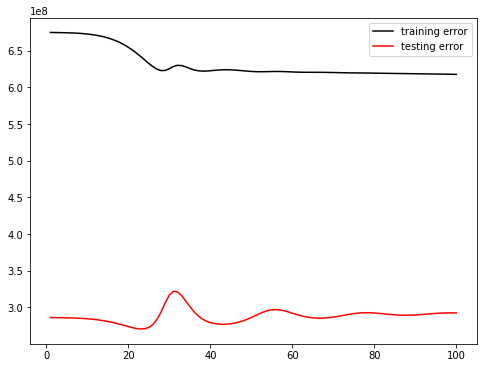

In [76]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.show()